In [370]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, timedelta
from matplotlib.pyplot import figure
import random

# modeling and metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error as mape


#feature selection
from boruta import BorutaPy
from sklearn.feature_selection import RFE, RFECV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Read Data and choose which columns to keep / drop

In [527]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
comp = pd.read_excel('Competitive variables 4.27 v2.xlsx').set_index('Date').iloc[:,:7]

corr_matrix = comp.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features 
comp.drop(to_drop, axis=1, inplace=True)

comp.head()

,BMO-TV-Imps,CIBC-TV-Imps,DESJ-TV-Imps,Manu-TV-Imps,PCOC-TV-Imps,RBC-TV-Imps,TD-TV-Imps
Date,,,,,,,
2018-10-22,5709.564353,28183.777724,938.422354,4533.444458,134.911384,56544.621744,30158.091329
2018-10-29,0.000000,23114.681289,15606.247551,8305.902687,0.000000,41602.210326,10764.661156
2018-11-05,0.000000,25198.423888,26847.867721,7276.690758,191.458509,72006.193336,12400.483450
2018-11-12,1.807658,24899.178233,24982.910024,8538.265904,18.611850,39264.933285,13328.375276
2018-11-19,507.013705,20230.862339,26781.416286,6555.459005,4.564375,66367.133056,12610.727589


In [528]:
bus = pd.read_excel('Internal Data 4.26.22.xlsx').set_index('Date')
bus.head()

,Calls answered - GB,Chats answered - GB,Emails answered - GB,Calls answered - GRS,Chats Answered - GRS,Emails answered - GRS,Chat - IND,Calls - IND,Advisor,Manager,SAA,CCC-GRS,CCC-GB,Individual Wealth (Client Satisfaction),Individual Wealth (Advisor Satisfaction ),Individual Protection (Client Satisfaction),Individual Protection (Advisor Satisfaction),IND and GRP Client Count,IND and GRP Churn Rate,IND Client Count,IND Churn Rate,GB Client Count,GB Churn Rate,GRS Client Count,GRS Churn Rate,GB and GRS Client Count,GB and GRS Churn Rate
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-10-22,46622.0,9068.0,745.0,8397.0,884.0,0.0,555.0,40685.0,2915,309,396,0.0,0.0,0.0,0.0,0.0,0.0,194871.0,0.0056,2128344.0,-0.0002,2845147.0,0.0040,889396.0,0.0021,435779.0,0.0067
2018-10-29,46312.0,8690.0,646.0,9091.0,840.0,0.0,514.0,40054.0,2922,309,398,0.0,0.0,0.0,0.0,0.0,0.0,194871.0,0.0056,2128344.0,-0.0002,2845147.0,0.0040,889396.0,0.0021,435779.0,0.0067
2018-11-05,47865.0,8861.0,709.0,9553.0,863.0,0.0,572.0,40248.0,2902,309,407,0.0,0.0,0.0,0.0,0.0,0.0,195572.0,0.0036,2128344.0,0.0000,2868143.0,0.0081,890051.0,0.0007,436236.0,0.0010
2018-11-12,46979.0,9107.0,675.0,10182.0,853.0,0.0,620.0,36675.0,2903,307,410,0.0,0.0,0.0,0.0,0.0,0.0,195572.0,0.0036,2128344.0,0.0000,2868143.0,0.0081,890051.0,0.0007,436236.0,0.0010
2018-11-19,46535.0,9518.0,653.0,10140.0,816.0,0.0,832.0,38694.0,2902,306,412,0.0,0.0,0.0,0.0,0.0,0.0,195572.0,0.0036,2128344.0,0.0000,2868143.0,0.0081,890051.0,0.0007,436236.0,0.0010


In [645]:
ext = pd.read_excel('External Data 4.26.xlsx').set_index('Date')

'''
Drop correlated columns with greater than 0.95 pearson correlation

https://stackoverflow.com/questions/29294983/how-to-calculate-correlation-between-all-columns-and-remove-highly-correlated-on
'''
corr_matrix = ext.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features 
ext.drop(to_drop, axis=1, inplace=True)

In [649]:
# add a feature for Quarterly seasonality 
ext['quarter'] = ext.index.quarter
ext = pd.get_dummies(ext,columns=['quarter'])
ext.head()

,Bank rate,Chartered bank - consumer loan rate,Selected Government of Canada benchmark bond yields 2 year,Selected Government of Canada benchmark bond yields long term,Chartered banks - 90 day term deposits,Chartered bank - conventional mortgage 1 year,Chartered bank - conventional mortgage 3 year,Chartered bank - 5 year personal fixed term,"Chartered bank - daily interest savings (balance over $100,000)",Chartered bank - Guaranteed Investment Certificates 1 year,Chartered bank - Guaranteed Investment Certificates 5 year,"Real return bonds, long-term",All other liabilities and capital,Treasury Bills,Securities purchased under resale agreements,Government of Canada,Weekly BCPI Total - v52673503,Weekly BCPI Excluding Energy - v52673504,Weekly BCPI Forestry - v52673509,Unemployment Rate Aged 15 and Over All Persons for Canada,Market Yield on U.S. Treasury Securities at 5-Year Constant Maturity,Christmas Day,Boxing Day,New Year's Day,Family Day,Good Friday,Easter Monday,Victoria Day,Canada Day,Civic Holiday,Labour Day,Thanksgiving,RRSP Season,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,Brandwatch Social Mentions,Infegy Social Mentions,Web-Facebook Interactions,Web-Facebook Shares,Web-Facebook Comments,Web-Twitter Influencer Shares,Web-Pinterest Interactions,quarter_1,quarter_2,quarter_3,quarter_4
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-10-22,2.0,9.13,2.30,2.47,0.05,3.64,4.29,1.28,0.05,1.08,1.6,0.77,4146,26068,8111,24863,402.97,328.03,391.65,0.0,3.050,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1351,172,268,19,1,0,0,0,1
2018-10-29,2.0,9.13,2.33,2.52,0.05,3.64,4.29,1.28,0.05,1.08,1.6,0.81,3698,26076,8108,25036,399.37,327.26,392.02,0.0,2.950,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,3060,363,479,43,2,0,0,0,1
2018-11-05,2.0,9.13,2.35,2.55,0.05,3.64,4.29,1.45,0.05,1.08,1.6,0.83,3598,25319,8111,22024,384.96,330.92,405.33,5.2,2.990,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,95,38,11,28,0,0,0,0,1
2018-11-12,2.0,9.13,2.27,2.46,0.05,3.64,4.29,1.45,0.05,1.08,2.2,0.76,3833,25327,8110,22254,368.65,330.29,417.75,5.2,3.065,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,45,12,8,9,0,0,0,0,1
2018-11-19,2.0,9.13,2.23,2.41,0.05,3.64,4.29,1.45,0.05,1.08,2.2,0.75,3794,25071,8113,22602,373.81,329.89,424.23,5.2,2.930,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,3332,408,808,78,2,0,0,0,1


In [530]:
add = pd.read_excel('Additional breakouts 4.27.xlsx').set_index('Date')
add.head()

,Facebook-Brand,Facebook-GO,Facebook-Lumino,Facebook-Other,Facebook-Sponsorship,LinkedIn EN-Brand,LinkedIn EN-Lumino,LinkedIn EN-Other,LinkedIn FR-Brand,LinkedIn FR-Lumino,LinkedIn FR-Other,Facebook-Brand-DSP,Facebook-GO-DSP,Facebook-Lumino-DSP,Facebook-Other-DSP,Facebook-Sponsorship-DSP,LinkedIn EN-Brand-DSP,LinkedIn EN-Lumino-DSP,LinkedIn EN-Other-DSP,LinkedIn FR-Brand-DSP,LinkedIn FR-Lumino-DSP,LinkedIn FR-Other-DSP,Native-DV360-Brand,Native-DV360-GO,Native-DV360-Lumino,Native-DCM-Brand,Native-DCM-GO,Native-DCM-Lumino,Native-DCM-Other,Native-DCM-Sponsorship,Display-DCM-Brand,Display-DCM-GO,Display-DCM-Lumino,Display-DCM-Lumino-B2B,Display-DCM-Other,Display-DCM-Sponsorship,Display-DV360-Brand,Display-DV360-GO,Display-DV360-Lumino,Display-DV360-Other,Display-DV360-Sponsorship,Display-Amazon DSP-Lumino,Display-Yahoo DSP-Lumino,Display-Yahoo DSP-Other,Video-StackAdapt-CTV-Lumino,Video-DV360-Brand,Video-DV360-Lumino,Video-DV360-Other,Video-DV360-Sponsorships,Video-DCM-Brand,YouTube-DV360-Brand,YouTube-DV360-GO,YouTube-DV360-Lumino,YouTube-DV360-Other,YouTube-DV360-Sponsorships,CTV-DV360-Brand,Video-DCM-Lumino,Video-DCM-Other,Video-DCM-Sponsorship,Video-Amazon DSP-Lumino,Video-Tremor TV-Brand,Spotify-Lumino,Spotify-Brand
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-10-22,0,0,1506607,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2018-10-29,5052667,0,11095943,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2018-11-05,5378111,0,11778066,0,0,0,0,0,0,0,0,0,0,0,74775,0,0,0,0,0,0,0,0,0,25532,0,0,0,0,0,0,0,0,11092195,0,0,0,0,0,0,0.0,0,0,0,0,0,112398,0,0,0,0,0,288011,0,0,0,0,0,0,0,0,0,0
2018-11-12,6553877,0,10857230,0,223378,0,0,0,0,0,0,0,0,0,1271418,0,0,0,0,0,0,0,0,0,771722,0,0,0,0,82849,0,0,0,9264187,0,201013,0,0,0,0,308885.0,0,0,0,0,0,449695,0,43,0,2323178,0,1395040,0,47171,0,0,0,0,0,0,0,0
2018-11-19,5687274,0,11383924,0,193331,0,0,0,0,0,0,0,0,0,1635480,0,0,0,0,0,0,0,0,0,1092830,0,0,0,0,110233,0,0,0,9379807,0,101892,0,0,0,0,463930.0,0,0,0,0,41843,537574,0,341,56665,2515211,0,1245402,0,79011,0,0,0,470,0,0,0,0


In [531]:
main = pd.read_excel('Media Variables 4.27.xlsx').set_index('Date')
main.drop(main.iloc[:,1:15],axis=1,inplace=True)
main.drop(["Search-GO Brand", "Search-GO Generic","Search-SLGI Brand","Search-SLGI Generic","Search-Other Brand","Search-Other Generic"], axis = 1, inplace = True)
main.head()

,FAA Lead Form Impressions,Search-National Brand,Search-National Generic,Search-Lumino Brand,Search-Lumino Generic,Social-Brand,Social-GO,Social-Lumino,Social-Sponsorship,Social-Other,Display-Brand,Display-Lumino,Display-GO,Display-Sponsorship,Display-Other,Native-Brand,Native-Lumino,Native-GO,Native-Sponsorship,Native-Other,Video-Brand,Video-Lumino,Video-Sponsorship,Video-Other,DigitalAudio-Brand,DigitalAudio-Lumino,DigitalAudio-Other,TV-Total-Brand-Imps,TV-Total-Lumino-Imps,TV-Total-Spon-Imps,TV-Conv-Brand-Imps,TV-Conv-Lumino-Imps,TV-Conv-Sponsorship-Imps,TV-Spec-Brand-Imps,TV-Spec-Lumino-Imps,TV-Spec-Spon-Imps,TV-Total-Brand-GRPs,TV-Total-Lumino-GRPs,TV-Total-Spon-GRPs,TV-Conv-Brand-GRPs,TV-Conv-Lumino-GRPs,TV-Conv-Sponsorship-GRPs,TV-Spec-Brand-GRPs,TV-Spec-Lumino-GRPs,TV-Spec-Spon-GRPs,OOH-Lumino,OOH-Brand,Radio-Brand,Radio-Lumino,Radio-QC
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-10-22,4456,59754,125031,0,125017,0,0,1506607.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3309.265026,0.0,0.000000,1303.848178,0.0,137.036022,2005.416848,0.0,0.000000,9.097,0.0,0.000,3.584259,0.0,1.726112,5.512866,0.0,0.000000,23130335.5,0.0,0.0,0.00,0.0
2018-10-29,4582,57271,104108,0,135685,5052667,0,11095943.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22099.645420,0.0,0.000000,6028.011481,0.0,392.986514,16071.633940,0.0,0.000000,60.752,0.0,0.000,16.570919,0.0,4.950070,44.180723,0.0,0.000000,45742057.5,2203168.0,0.0,444.45,0.0
2018-11-05,3606,41938,74833,0,135940,5378111,0,11778066.0,0,0.0,0,0,0,0,0,0,25532,0,0,0,0,400409,0,0,0,0,0,38956.383300,0.0,0.000000,10696.036100,0.0,300.186056,28260.347210,0.0,0.000000,107.091,0.0,0.000,29.403267,0.0,7.359311,77.687327,0.0,0.000000,48569474.5,2608168.0,0.0,444.32,0.0
2018-11-12,4118,38689,60305,0,52676,6553877,0,10857230.0,223378,0.0,0,0,0,509898,0,0,771722,0,82849,0,2323178,1844735,47214,0,0,0,0,37895.310310,0.0,899.010218,7964.624007,0.0,3538.850593,29930.686300,0.0,899.010218,104.174,0.0,2.471,21.894641,0.0,86.757673,82.279040,0.0,2.471368,47643305.0,2608168.0,0.0,444.01,0.0
2018-11-19,4863,48682,88334,0,73479,5687274,0,11383924.0,193331,0.0,0,0,0,565822,0,0,1092830,0,110233,0,2613719,1782976,79822,0,228210,0,0,39706.526820,0.0,597.541659,8791.820433,0.0,4994.204725,30914.706390,0.0,597.541659,109.153,0.0,1.643,24.168601,0.0,122.436927,84.984096,0.0,1.642633,49494775.5,2608168.0,0.0,443.22,0.0


# Combine data

In [776]:
data = pd.concat([main, add, comp, bus, ext], axis=1).fillna(0)
data.head()

,FAA Lead Form Impressions,Search-National Brand,Search-National Generic,Search-Lumino Brand,Search-Lumino Generic,Social-Brand,Social-GO,Social-Lumino,Social-Sponsorship,Social-Other,Display-Brand,Display-Lumino,Display-GO,Display-Sponsorship,Display-Other,Native-Brand,Native-Lumino,Native-GO,Native-Sponsorship,Native-Other,Video-Brand,Video-Lumino,Video-Sponsorship,Video-Other,DigitalAudio-Brand,DigitalAudio-Lumino,DigitalAudio-Other,TV-Total-Brand-Imps,TV-Total-Lumino-Imps,TV-Total-Spon-Imps,TV-Conv-Brand-Imps,TV-Conv-Lumino-Imps,TV-Conv-Sponsorship-Imps,TV-Spec-Brand-Imps,TV-Spec-Lumino-Imps,TV-Spec-Spon-Imps,TV-Total-Brand-GRPs,TV-Total-Lumino-GRPs,TV-Total-Spon-GRPs,TV-Conv-Brand-GRPs,TV-Conv-Lumino-GRPs,TV-Conv-Sponsorship-GRPs,TV-Spec-Brand-GRPs,TV-Spec-Lumino-GRPs,TV-Spec-Spon-GRPs,OOH-Lumino,OOH-Brand,Radio-Brand,Radio-Lumino,Radio-QC,Facebook-Brand,Facebook-GO,Facebook-Lumino,Facebook-Other,Facebook-Sponsorship,LinkedIn EN-Brand,LinkedIn EN-Lumino,LinkedIn EN-Other,LinkedIn FR-Brand,LinkedIn FR-Lumino,LinkedIn FR-Other,Facebook-Brand-DSP,Facebook-GO-DSP,Facebook-Lumino-DSP,Facebook-Other-DSP,Facebook-Sponsorship-DSP,LinkedIn EN-Brand-DSP,LinkedIn EN-Lumino-DSP,LinkedIn EN-Other-DSP,LinkedIn FR-Brand-DSP,LinkedIn FR-Lumino-DSP,LinkedIn FR-Other-DSP,Native-DV360-Brand,Native-DV360-GO,Native-DV360-Lumino,Native-DCM-Brand,Native-DCM-GO,Native-DCM-Lumino,Native-DCM-Other,Native-DCM-Sponsorship,Display-DCM-Brand,Display-DCM-GO,Display-DCM-Lumino,Display-DCM-Lumino-B2B,Display-DCM-Other,Display-DCM-Sponsorship,Display-DV360-Brand,Display-DV360-GO,Display-DV360-Lumino,Display-DV360-Other,Display-DV360-Sponsorship,Display-Amazon DSP-Lumino,Display-Yahoo DSP-Lumino,Display-Yahoo DSP-Other,Video-StackAdapt-CTV-Lumino,Video-DV360-Brand,Video-DV360-Lumino,Video-DV360-Other,Video-DV360-Sponsorships,Video-DCM-Brand,YouTube-DV360-Brand,YouTube-DV360-GO,YouTube-DV360-Lumino,YouTube-DV360-Other,YouTube-DV360-Sponsorships,CTV-DV360-Brand,Video-DCM-Lumino,Video-DCM-Other,Video-DCM-Sponsorship,Video-Amazon DSP-Lumino,Video-Tremor TV-Brand,Spotify-Lumino,Spotify-Brand,BMO-TV-Imps,CIBC-TV-Imps,DESJ-TV-Imps,Manu-TV-Imps,PCOC-TV-Imps,RBC-TV-Imps,TD-TV-Imps,Calls answered - GB,Chats answered - GB,Emails answered - GB,Calls answered - GRS,Chats Answered - GRS,Emails answered - GRS,Chat - IND,Calls - IND,Advisor,Manager,SAA,CCC-GRS,CCC-GB,Individual Wealth (Client Satisfaction),Individual Wealth (Advisor Satisfaction ),Individual Protection (Client Satisfaction),Individual Protection (Advisor Satisfaction),IND and GRP Client Count,IND and GRP Churn Rate,IND Client Count,IND Churn Rate,GB Client Count,GB Churn Rate,GRS Client Count,GRS Churn Rate,GB and GRS Client Count,GB and GRS Churn Rate,Bank rate,Chartered bank - consumer loan rate,Selected Government of Canada benchmark bond yields 2 year,Selected Government of Canada benchmark bond yields long term,Chartered banks - 90 day term deposits,Chartered bank - conventional mortgage 1 year,Chartered bank - conventional mortgage 3 year,Chartered bank - 5 year personal fixed term,"Chartered bank - daily interest savings (balance over $100,000)",Chartered bank - Guaranteed Investment Certificates 1 year,Chartered bank - Guaranteed Investment Certificates 5 year,"Real return bonds, long-term",All other liabilities and capital,Treasury Bills,Securities purchased under resale agreements,Government of Canada,Weekly BCPI Total - v52673503,Weekly BCPI Excluding Energy - v52673504,Weekly BCPI Forestry - v52673509,Unemployment Rate Aged 15 and Over All Persons for Canada,Market Yield on U.S. Treasury Securities at 5-Year Constant Maturity,Christmas Day,Boxing Day,New Year's Day,Family Day,Good Friday,Easter Monday,Victoria Day,Canada Day,Civic Holiday,Labour Day,Thanksgiving,RRSP Season,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,r

In [651]:
data.shape

(183, 197)

In [652]:
(data.index.max()+ timedelta(7) - data.index.min())/7

Timedelta('183 days 00:00:00')

# EDA on y variable

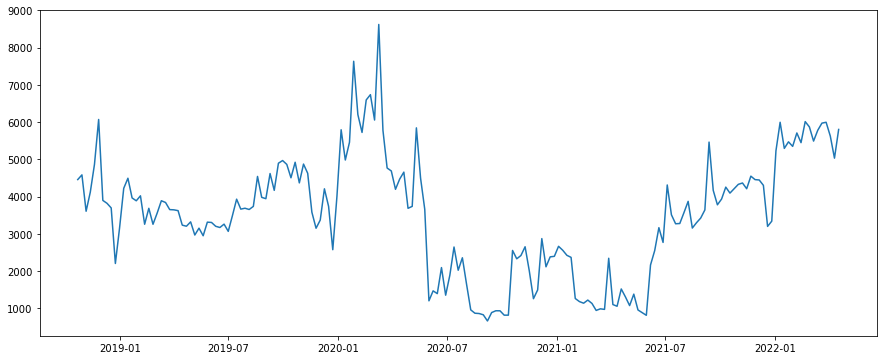

In [630]:
plt.figure(figsize=(15, 6))
plt.plot(data['FAA Lead Form Impressions'])

# Create Holdout Data and Model Data

In [789]:
#Leave last quarter as prediction
data_holdout = data['2021-09-13':'2021-12-27'].copy()
data_model = data['2018-10-22':'2021-09-06'].copy()
print("Model period is from", min(data_model.index).strftime("%Y-%m-%d") , "to" , max(data_model.index).strftime("%Y-%m-%d"))
print("Holdout period is from", min(data_holdout.index).strftime("%Y-%m-%d") , "to" , max(data_holdout.index).strftime("%Y-%m-%d"))

Model period is from 2018-10-22 to 2021-09-06
Holdout period is from 2021-09-13 to 2021-12-27


# Transform the Media Data

In [790]:
data_model.head()

,FAA Lead Form Impressions,Search-National Brand,Search-National Generic,Search-Lumino Brand,Search-Lumino Generic,Social-Brand,Social-GO,Social-Lumino,Social-Sponsorship,Social-Other,Display-Brand,Display-Lumino,Display-GO,Display-Sponsorship,Display-Other,Native-Brand,Native-Lumino,Native-GO,Native-Sponsorship,Native-Other,Video-Brand,Video-Lumino,Video-Sponsorship,Video-Other,DigitalAudio-Brand,DigitalAudio-Lumino,DigitalAudio-Other,TV-Total-Brand-Imps,TV-Total-Lumino-Imps,TV-Total-Spon-Imps,TV-Conv-Brand-Imps,TV-Conv-Lumino-Imps,TV-Conv-Sponsorship-Imps,TV-Spec-Brand-Imps,TV-Spec-Lumino-Imps,TV-Spec-Spon-Imps,TV-Total-Brand-GRPs,TV-Total-Lumino-GRPs,TV-Total-Spon-GRPs,TV-Conv-Brand-GRPs,TV-Conv-Lumino-GRPs,TV-Conv-Sponsorship-GRPs,TV-Spec-Brand-GRPs,TV-Spec-Lumino-GRPs,TV-Spec-Spon-GRPs,OOH-Lumino,OOH-Brand,Radio-Brand,Radio-Lumino,Radio-QC,Facebook-Brand,Facebook-GO,Facebook-Lumino,Facebook-Other,Facebook-Sponsorship,LinkedIn EN-Brand,LinkedIn EN-Lumino,LinkedIn EN-Other,LinkedIn FR-Brand,LinkedIn FR-Lumino,LinkedIn FR-Other,Facebook-Brand-DSP,Facebook-GO-DSP,Facebook-Lumino-DSP,Facebook-Other-DSP,Facebook-Sponsorship-DSP,LinkedIn EN-Brand-DSP,LinkedIn EN-Lumino-DSP,LinkedIn EN-Other-DSP,LinkedIn FR-Brand-DSP,LinkedIn FR-Lumino-DSP,LinkedIn FR-Other-DSP,Native-DV360-Brand,Native-DV360-GO,Native-DV360-Lumino,Native-DCM-Brand,Native-DCM-GO,Native-DCM-Lumino,Native-DCM-Other,Native-DCM-Sponsorship,Display-DCM-Brand,Display-DCM-GO,Display-DCM-Lumino,Display-DCM-Lumino-B2B,Display-DCM-Other,Display-DCM-Sponsorship,Display-DV360-Brand,Display-DV360-GO,Display-DV360-Lumino,Display-DV360-Other,Display-DV360-Sponsorship,Display-Amazon DSP-Lumino,Display-Yahoo DSP-Lumino,Display-Yahoo DSP-Other,Video-StackAdapt-CTV-Lumino,Video-DV360-Brand,Video-DV360-Lumino,Video-DV360-Other,Video-DV360-Sponsorships,Video-DCM-Brand,YouTube-DV360-Brand,YouTube-DV360-GO,YouTube-DV360-Lumino,YouTube-DV360-Other,YouTube-DV360-Sponsorships,CTV-DV360-Brand,Video-DCM-Lumino,Video-DCM-Other,Video-DCM-Sponsorship,Video-Amazon DSP-Lumino,Video-Tremor TV-Brand,Spotify-Lumino,Spotify-Brand,BMO-TV-Imps,CIBC-TV-Imps,DESJ-TV-Imps,Manu-TV-Imps,PCOC-TV-Imps,RBC-TV-Imps,TD-TV-Imps,Calls answered - GB,Chats answered - GB,Emails answered - GB,Calls answered - GRS,Chats Answered - GRS,Emails answered - GRS,Chat - IND,Calls - IND,Advisor,Manager,SAA,CCC-GRS,CCC-GB,Individual Wealth (Client Satisfaction),Individual Wealth (Advisor Satisfaction ),Individual Protection (Client Satisfaction),Individual Protection (Advisor Satisfaction),IND and GRP Client Count,IND and GRP Churn Rate,IND Client Count,IND Churn Rate,GB Client Count,GB Churn Rate,GRS Client Count,GRS Churn Rate,GB and GRS Client Count,GB and GRS Churn Rate,Bank rate,Chartered bank - consumer loan rate,Selected Government of Canada benchmark bond yields 2 year,Selected Government of Canada benchmark bond yields long term,Chartered banks - 90 day term deposits,Chartered bank - conventional mortgage 1 year,Chartered bank - conventional mortgage 3 year,Chartered bank - 5 year personal fixed term,"Chartered bank - daily interest savings (balance over $100,000)",Chartered bank - Guaranteed Investment Certificates 1 year,Chartered bank - Guaranteed Investment Certificates 5 year,"Real return bonds, long-term",All other liabilities and capital,Treasury Bills,Securities purchased under resale agreements,Government of Canada,Weekly BCPI Total - v52673503,Weekly BCPI Excluding Energy - v52673504,Weekly BCPI Forestry - v52673509,Unemployment Rate Aged 15 and Over All Persons for Canada,Market Yield on U.S. Treasury Securities at 5-Year Constant Maturity,Christmas Day,Boxing Day,New Year's Day,Family Day,Good Friday,Easter Monday,Victoria Day,Canada Day,Civic Holiday,Labour Day,Thanksgiving,RRSP Season,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,r

In [791]:
data_model.columns.get_loc('TD-TV-Imps')

119

In [770]:
data_model.iloc[:,1:data_model.columns.get_loc('TD-TV-Imps')+1]

,Search-National Brand,Search-National Generic,Search-Lumino Brand,Search-Lumino Generic,Social-Brand,Social-GO,Social-Lumino,Social-Sponsorship,Social-Other,Display-Brand,Display-Lumino,Display-GO,Display-Sponsorship,Display-Other,Native-Brand,Native-Lumino,Native-GO,Native-Sponsorship,Native-Other,Video-Brand,Video-Lumino,Video-Sponsorship,Video-Other,DigitalAudio-Brand,DigitalAudio-Lumino,DigitalAudio-Other,TV-Total-Brand-Imps,TV-Total-Lumino-Imps,TV-Total-Spon-Imps,TV-Conv-Brand-Imps,TV-Conv-Lumino-Imps,TV-Conv-Sponsorship-Imps,TV-Spec-Brand-Imps,TV-Spec-Lumino-Imps,TV-Spec-Spon-Imps,TV-Total-Brand-GRPs,TV-Total-Lumino-GRPs,TV-Total-Spon-GRPs,TV-Conv-Brand-GRPs,TV-Conv-Lumino-GRPs,TV-Conv-Sponsorship-GRPs,TV-Spec-Brand-GRPs,TV-Spec-Lumino-GRPs,TV-Spec-Spon-GRPs,OOH-Lumino,OOH-Brand,Radio-Brand,Radio-Lumino,Radio-QC,Facebook-Brand,Facebook-GO,Facebook-Lumino,Facebook-Other,Facebook-Sponsorship,LinkedIn EN-Brand,LinkedIn EN-Lumino,LinkedIn EN-Other,LinkedIn FR-Brand,LinkedIn FR-Lumino,LinkedIn FR-Other,Facebook-Brand-DSP,Facebook-GO-DSP,Facebook-Lumino-DSP,Facebook-Other-DSP,Facebook-Sponsorship-DSP,LinkedIn EN-Brand-DSP,LinkedIn EN-Lumino-DSP,LinkedIn EN-Other-DSP,LinkedIn FR-Brand-DSP,LinkedIn FR-Lumino-DSP,LinkedIn FR-Other-DSP,Native-DV360-Brand,Native-DV360-GO,Native-DV360-Lumino,Native-DCM-Brand,Native-DCM-GO,Native-DCM-Lumino,Native-DCM-Other,Native-DCM-Sponsorship,Display-DCM-Brand,Display-DCM-GO,Display-DCM-Lumino,Display-DCM-Lumino-B2B,Display-DCM-Other,Display-DCM-Sponsorship,Display-DV360-Brand,Display-DV360-GO,Display-DV360-Lumino,Display-DV360-Other,Display-DV360-Sponsorship,Display-Amazon DSP-Lumino,Display-Yahoo DSP-Lumino,Display-Yahoo DSP-Other,Video-StackAdapt-CTV-Lumino,Video-DV360-Brand,Video-DV360-Lumino,Video-DV360-Other,Video-DV360-Sponsorships,Video-DCM-Brand,YouTube-DV360-Brand,YouTube-DV360-GO,YouTube-DV360-Lumino,YouTube-DV360-Other,YouTube-DV360-Sponsorships,CTV-DV360-Brand,Video-DCM-Lumino,Video-DCM-Other,Video-DCM-Sponsorship,Video-Amazon DSP-Lumino,Video-Tremor TV-Brand,Spotify-Lumino,Spotify-Brand,BMO-TV-Imps,CIBC-TV-Imps,DESJ-TV-Imps,Manu-TV-Imps,PCOC-TV-Imps,RBC-TV-Imps,TD-TV-Imps
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-10-22,59754,125031,0,125017,0,0,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1506607,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-29,57271,104108,0,135685,5052667,0,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5052667,0,11095943,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-11-05,41938,74833,0,135940,5378111,0,NaN,0,NaN,0,0,0,0,0,0,25532,0,0,0,0,400409,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5378111,0,11778066,0,0,0,0,0,0,0,0,0,0,0,74775,0,0,0,0,0,0,0,0,0,25532,0,0,0,0,0,0,0,0,11092195,0,0,0,0,0,0,NaN,0,0,0,0,0,112398,0,0,0,0,0,288011,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-11-12,38689,60305,0,52676,6553877,0,NaN,223378,NaN,0,0,0,509898,0,0,771722,0,82849,0,2323178,1844735,47214,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6553877,0,10857230,0,223378,0,0,0,0,0,0,0,0,0,1271418,0,0,0,0,0,0,0,0,0,771722,0,0,0,0,82849,0,0,0,9264187,0,201013,0,0,0,0,NaN,0,0,0,0,0,449695,0,43,0,2323178,0,1395040,0,47171,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-11-19,48682,88334,0,73479,5687274,0,NaN,193331,NaN,0,0,0,565822,0,0,1092830,0,110233,0,2613719,1782976,79822,0,228210,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5687

# Transformation Functions

In [283]:
def gamma_trans(x,rho=100000,gamma=1):
    """Applies the gamma function to the data
    INPUT:
    x: numpy array of spends
    rho: the parameter which is varied to determine the degree of saturation
    gamma: the gamma in the gamma function, typically set to 1
    OUTPUT:
    y: numpy array of spend with the gamma fcn applied"""
    xg = x**gamma
    return (xg/(xg+(rho**gamma)))

In [732]:
def s_trans(x,b=.5,c=-2):
    """
    The b parameter mostly affects the saturation,
    The c parameter determines the diminishing effect on low adstock values.
    """
    adstock = np.mean(x)+0.0000000001 #To ensure divide by 0 doesn't occur 
    s = 1/(1+b*(np.power(x/adstock,c)))
    return s

In [704]:
def carry(x,c=.8):
    """
    models an exponential carry over function
    """
    y= np.power(c,np.array(x))
    return y

In [290]:
s = data_model['Facebook-Brand']
rho = [800000,1000000,1200000]
gamma = [0.4, 0.80, 1.2, 1.6, 1.8]


curve_names = ["rho:" + str(a)+" gamma:"+str(b) for a in rho for b in gamma]
curve_data = [gamma_trans(s,a,b) for a in rho for b in gamma]

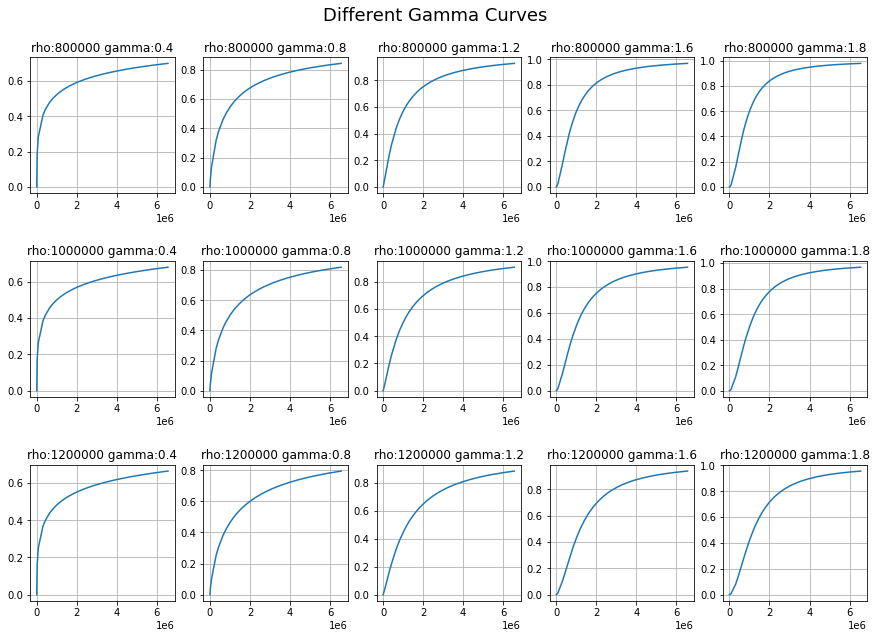

In [291]:
plt.figure(figsize=(15, 10))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Different Gamma Curves", fontsize=18, y=0.95)

for n, curve in enumerate(curve_names):
    ax = plt.subplot(3,5, n + 1)
    ax.plot(s.sort_values(),curve_data[n].sort_values())
    ax.set_title(curve)
    ax.yaxis.grid() 
    ax.xaxis.grid() 
    ax.set_xlabel("")

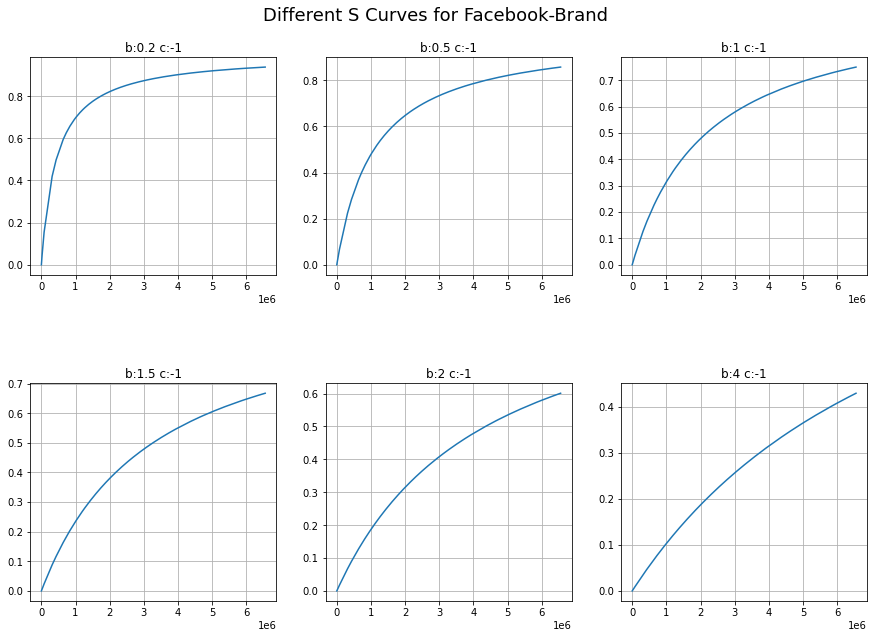

In [308]:
s = data_model['Facebook-Brand']
b = [.2,.5, 1, 1.5, 2, 4]
c = [-1]


curve_names = ["b:" + str(i)+" c:"+str(j) for i in b for j in c]
curve_data = [s_trans(s,i,j) for i in b for j in c]

plt.figure(figsize=(15, 10))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Different S Curves for "+s.name, fontsize=18, y=0.95)

for n, curve in enumerate(curve_names):
    ax = plt.subplot(2,3, n + 1)
    ax.plot(s.sort_values(),curve_data[n].sort_values())
    ax.set_title(curve)
    ax.yaxis.grid() 
    ax.xaxis.grid() 
    ax.set_xlabel("")

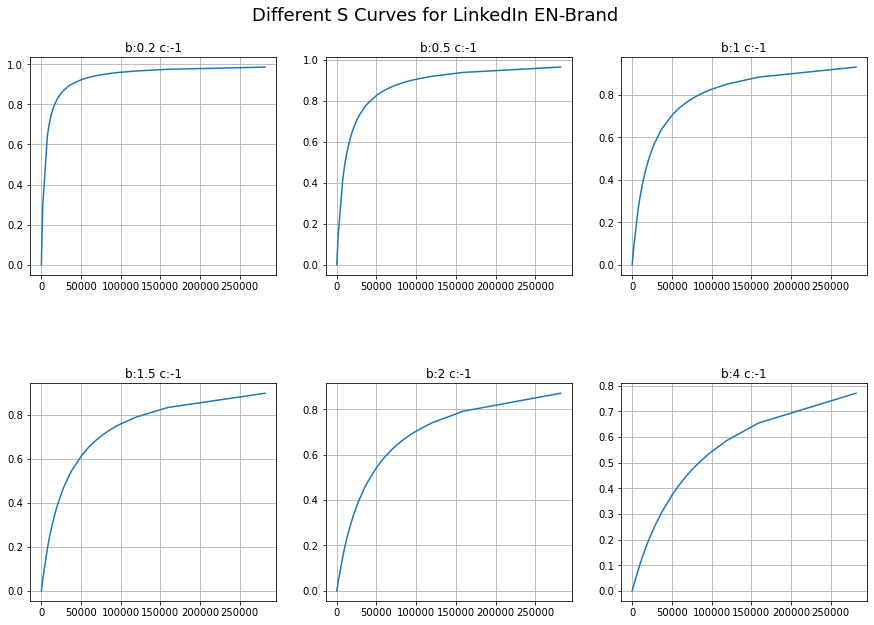

In [703]:
s = data_model['LinkedIn EN-Brand']
b = [.2,.5, 1, 1.5, 2, 4]
c = [-1]


curve_names = ["b:" + str(i)+" c:"+str(j) for i in b for j in c]
curve_data = [s_trans(s,i,j) for i in b for j in c]

plt.figure(figsize=(15, 10))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Different S Curves for "+s.name, fontsize=18, y=0.95)

for n, curve in enumerate(curve_names):
    ax = plt.subplot(2,3, n + 1)
    ax.plot(s.sort_values(),curve_data[n].sort_values())
    ax.set_title(curve)
    ax.yaxis.grid() 
    ax.xaxis.grid() 
    ax.set_xlabel("")

In [707]:
len(data_model['Facebook-Brand']), len(np.convolve(data_model['Facebook-Brand'],carry(np.linspace(0,data_model.shape[0]),.8)))

(151, 200)

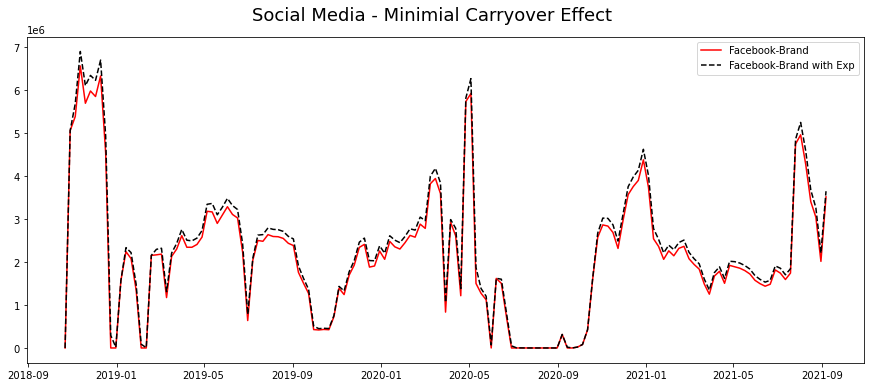

In [720]:
dd = np.array(data_model['Facebook-Brand'])
ddw = np.convolve(dd,carry(np.linspace(0,data_model.shape[0]),.4))
fig = plt.figure(figsize=(15,6))
plt.plot(data_model.index,dd,'r-',label = 'Facebook-Brand')
plt.plot(data_model.index,ddw[:151],'k--',label = 'Facebook-Brand with Exp')
plt.legend()
plt.suptitle('Social Media - Minimial Carryover Effect',fontsize=18, y=0.95)
plt.show()

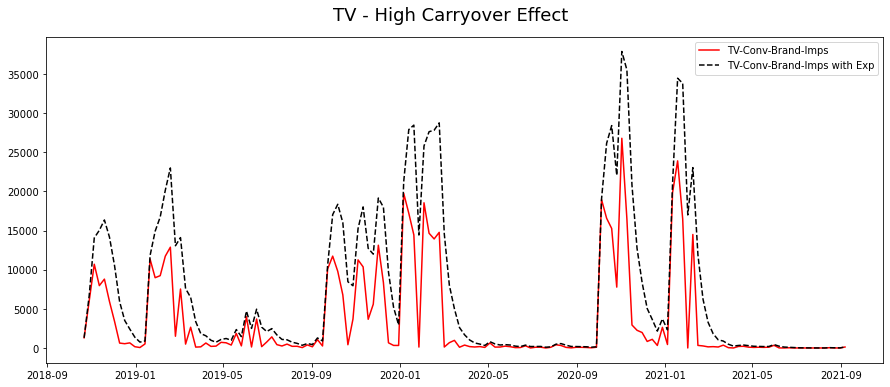

In [722]:
dd = np.array(data_model['TV-Conv-Brand-Imps'])
ddw = np.convolve(dd,carry(np.linspace(0,data_model.shape[0]),.8))
fig = plt.figure(figsize=(15,6))
plt.plot(data_model.index,dd,'r-',label = 'TV-Conv-Brand-Imps')
plt.plot(data_model.index,ddw[:151],'k--',label = 'TV-Conv-Brand-Imps with Exp')
plt.legend()
plt.suptitle('TV - High Carryover Effect',fontsize=18, y=0.95)
plt.show()

# Apply Functions to Media Variables

- Apply fast saturation/low carryover to digital display, social, native, search, audio 
- Apply medium saturation/medium carryover to online video
- Apply slow saturation/high carryover to tv, OOH and radio

In [792]:
'''
Fast saturation b = 0.2, Medium saturation b = 1, Slow saturation b = 2 
c = -1 for all as we want D-shaped curves, not S-shaped curves

Low carryover = 0.4, Medium carryover = 0.6, High carryover = 0.8
'''

media_transform = pd.DataFrame(columns = data_model.iloc[:,1:data_model.columns.get_loc('TD-TV-Imps')+1].columns,index=data_model.index)

for col in data_model.iloc[:,1:data_model.columns.get_loc('TD-TV-Imps')+1].columns:
    if any(x in col.lower() for x in ['video','ctv','youtube']):    
        carryover = np.convolve(data_model[col],carry(np.linspace(0,data_model.shape[0]),.6))[:len(data_model)]
        media_transform[col] = s_trans(carryover,b=1,c=-1)
    elif any(x in col.lower() for x in ['facebook','social','linkedin','twitter','search','display','native','audio','spotify']):
        carryover = np.convolve(data_model[col],carry(np.linspace(0,data_model.shape[0]),.4))[:len(data_model)]
        media_transform[col] = s_trans(carryover,b=0.2,c=-1)
    elif any(x in col.lower() for x in ['tv','ooh','radio']):
        carryover = np.convolve(data_model[col],carry(np.linspace(0,data_model.shape[0]),.8))[:len(data_model)]
        media_transform[col] = s_trans(carryover,b=2,c=-1)
    else:
        continue

C:\Users\NUPUR~1.GOK\AppData\Local\Temp/ipykernel_31716/3116124488.py:7: RuntimeWarning: divide by zero encountered in power
  s = 1/(1+b*(np.power(x/adstock,c)))


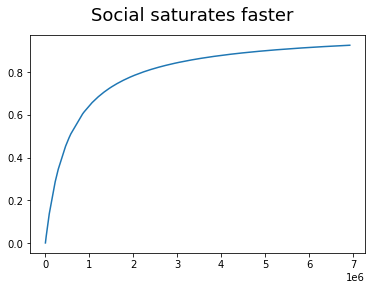

In [793]:
carryover = np.convolve(data_model['Social-Brand'],carry(np.linspace(0,data_model.shape[0]),.4))[:len(data_model)]
plt.plot(np.sort(carryover), media_transform['Social-Brand'].sort_values())
plt.suptitle('Social saturates faster', fontsize = 18)
plt.show()

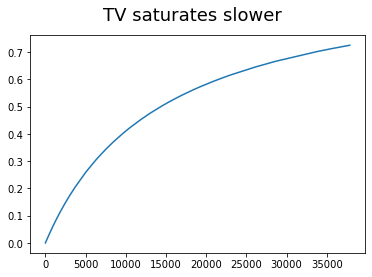

In [794]:
carryover = np.convolve(data_model['TV-Conv-Brand-Imps'],carry(np.linspace(0,data_model.shape[0]),.8))[:len(data_model)]
plt.plot(np.sort(carryover), media_transform['TV-Conv-Brand-Imps'].sort_values())
plt.suptitle('TV saturates slower', fontsize = 18)
plt.show()

In [795]:
media_transform.head()

,Search-National Brand,Search-National Generic,Search-Lumino Brand,Search-Lumino Generic,Social-Brand,Social-GO,Social-Lumino,Social-Sponsorship,Social-Other,Display-Brand,Display-Lumino,Display-GO,Display-Sponsorship,Display-Other,Native-Brand,Native-Lumino,Native-GO,Native-Sponsorship,Native-Other,Video-Brand,Video-Lumino,Video-Sponsorship,Video-Other,DigitalAudio-Brand,DigitalAudio-Lumino,DigitalAudio-Other,TV-Total-Brand-Imps,TV-Total-Lumino-Imps,TV-Total-Spon-Imps,TV-Conv-Brand-Imps,TV-Conv-Lumino-Imps,TV-Conv-Sponsorship-Imps,TV-Spec-Brand-Imps,TV-Spec-Lumino-Imps,TV-Spec-Spon-Imps,TV-Total-Brand-GRPs,TV-Total-Lumino-GRPs,TV-Total-Spon-GRPs,TV-Conv-Brand-GRPs,TV-Conv-Lumino-GRPs,TV-Conv-Sponsorship-GRPs,TV-Spec-Brand-GRPs,TV-Spec-Lumino-GRPs,TV-Spec-Spon-GRPs,OOH-Lumino,OOH-Brand,Radio-Brand,Radio-Lumino,Radio-QC,Facebook-Brand,Facebook-GO,Facebook-Lumino,Facebook-Other,Facebook-Sponsorship,LinkedIn EN-Brand,LinkedIn EN-Lumino,LinkedIn EN-Other,LinkedIn FR-Brand,LinkedIn FR-Lumino,LinkedIn FR-Other,Facebook-Brand-DSP,Facebook-GO-DSP,Facebook-Lumino-DSP,Facebook-Other-DSP,Facebook-Sponsorship-DSP,LinkedIn EN-Brand-DSP,LinkedIn EN-Lumino-DSP,LinkedIn EN-Other-DSP,LinkedIn FR-Brand-DSP,LinkedIn FR-Lumino-DSP,LinkedIn FR-Other-DSP,Native-DV360-Brand,Native-DV360-GO,Native-DV360-Lumino,Native-DCM-Brand,Native-DCM-GO,Native-DCM-Lumino,Native-DCM-Other,Native-DCM-Sponsorship,Display-DCM-Brand,Display-DCM-GO,Display-DCM-Lumino,Display-DCM-Lumino-B2B,Display-DCM-Other,Display-DCM-Sponsorship,Display-DV360-Brand,Display-DV360-GO,Display-DV360-Lumino,Display-DV360-Other,Display-DV360-Sponsorship,Display-Amazon DSP-Lumino,Display-Yahoo DSP-Lumino,Display-Yahoo DSP-Other,Video-StackAdapt-CTV-Lumino,Video-DV360-Brand,Video-DV360-Lumino,Video-DV360-Other,Video-DV360-Sponsorships,Video-DCM-Brand,YouTube-DV360-Brand,YouTube-DV360-GO,YouTube-DV360-Lumino,YouTube-DV360-Other,YouTube-DV360-Sponsorships,CTV-DV360-Brand,Video-DCM-Lumino,Video-DCM-Other,Video-DCM-Sponsorship,Video-Amazon DSP-Lumino,Video-Tremor TV-Brand,Spotify-Lumino,Spotify-Brand,BMO-TV-Imps,CIBC-TV-Imps,DESJ-TV-Imps,Manu-TV-Imps,PCOC-TV-Imps,RBC-TV-Imps,TD-TV-Imps
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-10-22,0.805514,0.945272,0.0,0.797229,0.000000,0.0,0.844682,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.053117,0.0,0.000000,0.083237,0.0,0.054786,0.043001,0.0,0.000000,0.053801,0.0,0.000000,0.084384,0.0,0.031640,0.043542,0.0,0.000000,0.741488,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.848935,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.077498,0.209762,0.027226,0.131795,0.021614,0.280623,0.147824
2018-10-29,0.808268,0.939053,0.0,0.818203,0.901154,0.0,0.975831,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.287153,0.0,0.000000,0.317599,0.0,0.163433,0.276771,0.0,0.000000,0.289930,0.0,0.000000,0.320845,0.0,0.099203,0.279395,0.0,0.000000,0.876761,0.216423,0.0,0.903799,0.0,0.917228,0.0,0.976593,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.040525,0.259891,0.324107,0.261688,0.010984,0.325750,0.129776
2018-11-05,0.759455,0.918386,0.0,0.819575,0.911074,0.0,0.978220,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.232479,0.0,0.000000,0.0,0.000000,0.570375,0.000000,0.0,0.000000,0.0,0.0,0.463201,0.0,0.000000,0.494648,0.0,0.183799,0.4

In [783]:
media_transform.shape, data_model.shape

((151, 119), (151, 197))

# Using a Genetic Algorithm with 5-Fold CV to select features

In [796]:
data_model.iloc[:,1:data_model.columns.get_loc('TD-TV-Imps')+1] = media_transform

In [797]:
data_model.head()

,FAA Lead Form Impressions,Search-National Brand,Search-National Generic,Search-Lumino Brand,Search-Lumino Generic,Social-Brand,Social-GO,Social-Lumino,Social-Sponsorship,Social-Other,Display-Brand,Display-Lumino,Display-GO,Display-Sponsorship,Display-Other,Native-Brand,Native-Lumino,Native-GO,Native-Sponsorship,Native-Other,Video-Brand,Video-Lumino,Video-Sponsorship,Video-Other,DigitalAudio-Brand,DigitalAudio-Lumino,DigitalAudio-Other,TV-Total-Brand-Imps,TV-Total-Lumino-Imps,TV-Total-Spon-Imps,TV-Conv-Brand-Imps,TV-Conv-Lumino-Imps,TV-Conv-Sponsorship-Imps,TV-Spec-Brand-Imps,TV-Spec-Lumino-Imps,TV-Spec-Spon-Imps,TV-Total-Brand-GRPs,TV-Total-Lumino-GRPs,TV-Total-Spon-GRPs,TV-Conv-Brand-GRPs,TV-Conv-Lumino-GRPs,TV-Conv-Sponsorship-GRPs,TV-Spec-Brand-GRPs,TV-Spec-Lumino-GRPs,TV-Spec-Spon-GRPs,OOH-Lumino,OOH-Brand,Radio-Brand,Radio-Lumino,Radio-QC,Facebook-Brand,Facebook-GO,Facebook-Lumino,Facebook-Other,Facebook-Sponsorship,LinkedIn EN-Brand,LinkedIn EN-Lumino,LinkedIn EN-Other,LinkedIn FR-Brand,LinkedIn FR-Lumino,LinkedIn FR-Other,Facebook-Brand-DSP,Facebook-GO-DSP,Facebook-Lumino-DSP,Facebook-Other-DSP,Facebook-Sponsorship-DSP,LinkedIn EN-Brand-DSP,LinkedIn EN-Lumino-DSP,LinkedIn EN-Other-DSP,LinkedIn FR-Brand-DSP,LinkedIn FR-Lumino-DSP,LinkedIn FR-Other-DSP,Native-DV360-Brand,Native-DV360-GO,Native-DV360-Lumino,Native-DCM-Brand,Native-DCM-GO,Native-DCM-Lumino,Native-DCM-Other,Native-DCM-Sponsorship,Display-DCM-Brand,Display-DCM-GO,Display-DCM-Lumino,Display-DCM-Lumino-B2B,Display-DCM-Other,Display-DCM-Sponsorship,Display-DV360-Brand,Display-DV360-GO,Display-DV360-Lumino,Display-DV360-Other,Display-DV360-Sponsorship,Display-Amazon DSP-Lumino,Display-Yahoo DSP-Lumino,Display-Yahoo DSP-Other,Video-StackAdapt-CTV-Lumino,Video-DV360-Brand,Video-DV360-Lumino,Video-DV360-Other,Video-DV360-Sponsorships,Video-DCM-Brand,YouTube-DV360-Brand,YouTube-DV360-GO,YouTube-DV360-Lumino,YouTube-DV360-Other,YouTube-DV360-Sponsorships,CTV-DV360-Brand,Video-DCM-Lumino,Video-DCM-Other,Video-DCM-Sponsorship,Video-Amazon DSP-Lumino,Video-Tremor TV-Brand,Spotify-Lumino,Spotify-Brand,BMO-TV-Imps,CIBC-TV-Imps,DESJ-TV-Imps,Manu-TV-Imps,PCOC-TV-Imps,RBC-TV-Imps,TD-TV-Imps,Calls answered - GB,Chats answered - GB,Emails answered - GB,Calls answered - GRS,Chats Answered - GRS,Emails answered - GRS,Chat - IND,Calls - IND,Advisor,Manager,SAA,CCC-GRS,CCC-GB,Individual Wealth (Client Satisfaction),Individual Wealth (Advisor Satisfaction ),Individual Protection (Client Satisfaction),Individual Protection (Advisor Satisfaction),IND and GRP Client Count,IND and GRP Churn Rate,IND Client Count,IND Churn Rate,GB Client Count,GB Churn Rate,GRS Client Count,GRS Churn Rate,GB and GRS Client Count,GB and GRS Churn Rate,Bank rate,Chartered bank - consumer loan rate,Selected Government of Canada benchmark bond yields 2 year,Selected Government of Canada benchmark bond yields long term,Chartered banks - 90 day term deposits,Chartered bank - conventional mortgage 1 year,Chartered bank - conventional mortgage 3 year,Chartered bank - 5 year personal fixed term,"Chartered bank - daily interest savings (balance over $100,000)",Chartered bank - Guaranteed Investment Certificates 1 year,Chartered bank - Guaranteed Investment Certificates 5 year,"Real return bonds, long-term",All other liabilities and capital,Treasury Bills,Securities purchased under resale agreements,Government of Canada,Weekly BCPI Total - v52673503,Weekly BCPI Excluding Energy - v52673504,Weekly BCPI Forestry - v52673509,Unemployment Rate Aged 15 and Over All Persons for Canada,Market Yield on U.S. Treasury Securities at 5-Year Constant Maturity,Christmas Day,Boxing Day,New Year's Day,Family Day,Good Friday,Easter Monday,Victoria Day,Canada Day,Civic Holiday,Labour Day,Thanksgiving,RRSP Season,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,r

In [798]:
data_model.shape

(151, 197)

In [799]:
X = data_model.drop('FAA Lead Form Impressions',axis=1).to_numpy()
y = data_model['FAA Lead Form Impressions'].to_numpy()
X.shape, y.shape

((151, 196), (151,))

In [800]:
y

array([4456, 4582, 3606, 4118, 4863, 6069, 3897, 3819, 3695, 2204, 3156,
       4222, 4492, 3963, 3887, 4020, 3257, 3685, 3256, 3558, 3888, 3841,
       3650, 3644, 3622, 3233, 3204, 3321, 2968, 3152, 2948, 3313, 3305,
       3202, 3170, 3260, 3066, 3489, 3930, 3663, 3687, 3653, 3736, 4540,
       3979, 3943, 4618, 4167, 4895, 4967, 4863, 4504, 4921, 4367, 4872,
       4625, 3581, 3150, 3369, 4208, 3737, 2574, 4011, 5793, 4981, 5459,
       7631, 6201, 5721, 6593, 6735, 6054, 8619, 5778, 4766, 4687, 4195,
       4469, 4656, 3685, 3737, 5844, 4494, 3658, 1202, 1469, 1395, 2094,
       1353, 1889, 2646, 2023, 2357, 1647,  959,  869,  861,  827,  661,
        887,  935,  934,  817,  817, 2554, 2330, 2417, 2653, 2008, 1259,
       1493, 2872, 2115, 2382, 2396, 2665, 2559, 2423, 2368, 1264, 1181,
       1138, 1222, 1131,  944,  987,  972, 2344, 1102, 1056, 1520, 1307,
       1074, 1381,  957,  884,  813, 2164, 2550, 3165, 2769, 4311, 3511,
       3270, 3277, 3569, 3871, 3155, 3298, 3423, 36

In [551]:
'''

Function to fit a model using a DNA and calculate fitness. 
Model fit is done using 5-fold CV and average RMSE of test fold is calculated as fitness. 


'''
def calculate_fitness(population,X,y):
    fitness = []
    lr = LinearRegression()
    scalar = StandardScaler()
    pipeline = Pipeline([('transformer', scalar), ('estimator', lr)])
    for i in np.arange(population.shape[0]):
        folds = KFold(n_splits = 5, shuffle = True, random_state = 42)
        scores = cross_val_score(pipeline, X[:,population[i,:]], y, scoring = 'neg_root_mean_squared_error', cv=folds)
        fitness.append(np.mean(scores))
    return fitness

In [552]:
'''
Function to generate a mating pool
Based on fitness, each member will get added to the mating pool a certain number of times
'''

def create_mating_pool(population, fitness, popmax):
    idx = random.choices(list(range(popmax)),weights = -1/fitness,k=popmax)
    return population[idx,:]

In [553]:
'''
Cross-over to create a new child 

'''

def crossover(parent_a,parent_b):
    #cross over randomly
    randarray = np.random.random(size=parent_a.shape)<.5
    parent_a[randarray] = parent_b[randarray]
    return parent_a

In [554]:
'''
Mutation: Based on the mutation probability, transform a random gene in the DNA 
'''

def mutate_matrix(mutationRate,child):
    #fill a random matrix
    rand_char = np.random.choice([True, False], size=(popmax,X.shape[1]))
    #determine mutations
    mutator = np.random.random(size=(popmax,child.shape[1]))<mutationRate
    #mutate the child where necessary
    child[mutator] = rand_char[mutator]
    return child

In [555]:
'''
Refill the population with children from the mating pool
'''

def generate_matrix(population, fitness, popmax, mutationRate):
    
    #Create mating pool 
    #mating_pool = [None] * popmax
    #create two parents
    p_a = create_mating_pool(population, fitness, popmax)
    p_b = create_mating_pool(population, fitness, popmax)
    crossed = crossover(p_a,p_b)
    new_pop = mutate_matrix(mutationRate,crossed)
    return new_pop

In [801]:
epochs = 1000
fitness_tracker = []
best_dna = None
best_fitness = float('-inf')

'''

Initialize a population. Each DNA is a list of True and False indicating whether a variable is included or not. 


'''
popmax = 300
population = np.random.choice([True, False], size=(popmax,X.shape[1]))
mutationRate = 0.001

for i in range(epochs):
    
    fitness = np.array(calculate_fitness(population,X,y))
    fitness_tracker.append(fitness)
    
    if max(fitness) > best_fitness:
            best_dna = population[np.where(fitness == max(fitness))[0],:]
            best_fitness = max(fitness)
            
    population = generate_matrix(population,fitness,popmax,mutationRate)
    print ("epoch: {0}, mean fitness: {1:.2f}, best fitness: {2:.2f}".format(i, np.mean(fitness), best_fitness))

epoch: 0, mean fitness: -58366818396422.28, best fitness: -990.37
epoch: 1, mean fitness: -47356696955813.66, best fitness: -979.59
epoch: 2, mean fitness: -18926896190527.91, best fitness: -898.57
epoch: 3, mean fitness: -26950885024314.38, best fitness: -898.57
epoch: 4, mean fitness: -9738301594357.92, best fitness: -848.38
epoch: 5, mean fitness: -905075430223.79, best fitness: -848.38
epoch: 6, mean fitness: -13574582965273.33, best fitness: -848.38
epoch: 7, mean fitness: -48305307469243.12, best fitness: -848.38
epoch: 8, mean fitness: -16464607165636.21, best fitness: -845.30
epoch: 9, mean fitness: -34663254157773.12, best fitness: -802.36
epoch: 10, mean fitness: -56119670913919.65, best fitness: -802.36
epoch: 11, mean fitness: -23314861348052.91, best fitness: -802.36
epoch: 12, mean fitness: -24875373617482.74, best fitness: -778.32
epoch: 13, mean fitness: -13102986514609.60, best fitness: -774.44
epoch: 14, mean fitness: -16708935267048.66, best fitness: -760.62
epoch: 1

epoch: 139, mean fitness: -672.00, best fitness: -498.41
epoch: 140, mean fitness: -673.35, best fitness: -498.41
epoch: 141, mean fitness: -676.75, best fitness: -498.41
epoch: 142, mean fitness: -665.30, best fitness: -498.41
epoch: 143, mean fitness: -663.48, best fitness: -498.41
epoch: 144, mean fitness: -668.01, best fitness: -498.41
epoch: 145, mean fitness: -654.28, best fitness: -498.41
epoch: 146, mean fitness: -663.79, best fitness: -490.24
epoch: 147, mean fitness: -660.10, best fitness: -490.24
epoch: 148, mean fitness: -657.38, best fitness: -490.24
epoch: 149, mean fitness: -649.09, best fitness: -490.24
epoch: 150, mean fitness: -652.19, best fitness: -480.38
epoch: 151, mean fitness: -651.46, best fitness: -480.38
epoch: 152, mean fitness: -649.04, best fitness: -480.38
epoch: 153, mean fitness: -641.46, best fitness: -480.38
epoch: 154, mean fitness: -644.39, best fitness: -474.27
epoch: 155, mean fitness: -638.53, best fitness: -474.27
epoch: 156, mean fitness: -637.

epoch: 281, mean fitness: -91471580662.55, best fitness: -410.62
epoch: 282, mean fitness: -502.49, best fitness: -410.62
epoch: 283, mean fitness: -503.60, best fitness: -405.37
epoch: 284, mean fitness: -500.90, best fitness: -402.39
epoch: 285, mean fitness: -501.58, best fitness: -402.39
epoch: 286, mean fitness: -501.65, best fitness: -402.39
epoch: 287, mean fitness: -499.78, best fitness: -402.39
epoch: 288, mean fitness: -498.56, best fitness: -402.39
epoch: 289, mean fitness: -497.63, best fitness: -402.39
epoch: 290, mean fitness: -501.36, best fitness: -402.39
epoch: 291, mean fitness: -498.19, best fitness: -402.39
epoch: 292, mean fitness: -499.86, best fitness: -402.39
epoch: 293, mean fitness: -499.52, best fitness: -402.39
epoch: 294, mean fitness: -495.80, best fitness: -402.39
epoch: 295, mean fitness: -492.40, best fitness: -402.39
epoch: 296, mean fitness: -492.03, best fitness: -402.39
epoch: 297, mean fitness: -493.36, best fitness: -402.39
epoch: 298, mean fitnes

epoch: 424, mean fitness: -450.83, best fitness: -389.43
epoch: 425, mean fitness: -451.72, best fitness: -389.43
epoch: 426, mean fitness: -453.12, best fitness: -389.43
epoch: 427, mean fitness: -451.59, best fitness: -389.43
epoch: 428, mean fitness: -460.02, best fitness: -389.43
epoch: 429, mean fitness: -452.41, best fitness: -389.43
epoch: 430, mean fitness: -452.92, best fitness: -389.43
epoch: 431, mean fitness: -452.15, best fitness: -389.43
epoch: 432, mean fitness: -452.93, best fitness: -389.43
epoch: 433, mean fitness: -451.06, best fitness: -389.43
epoch: 434, mean fitness: -452.82, best fitness: -389.43
epoch: 435, mean fitness: -451.35, best fitness: -380.63
epoch: 436, mean fitness: -448.43, best fitness: -380.63
epoch: 437, mean fitness: -450.87, best fitness: -380.63
epoch: 438, mean fitness: -449.24, best fitness: -380.63
epoch: 439, mean fitness: -451.38, best fitness: -380.63
epoch: 440, mean fitness: -449.61, best fitness: -380.63
epoch: 441, mean fitness: -4247

epoch: 567, mean fitness: -426.29, best fitness: -369.98
epoch: 568, mean fitness: -423.95, best fitness: -369.98
epoch: 569, mean fitness: -423.79, best fitness: -368.46
epoch: 570, mean fitness: -425.25, best fitness: -368.46
epoch: 571, mean fitness: -423.80, best fitness: -368.46
epoch: 572, mean fitness: -422.46, best fitness: -368.46
epoch: 573, mean fitness: -423.11, best fitness: -368.46
epoch: 574, mean fitness: -419.69, best fitness: -368.46
epoch: 575, mean fitness: -4823183517.08, best fitness: -368.46
epoch: 576, mean fitness: -417.50, best fitness: -368.46
epoch: 577, mean fitness: -414.99, best fitness: -368.46
epoch: 578, mean fitness: -416.42, best fitness: -368.46
epoch: 579, mean fitness: -418.92, best fitness: -368.46
epoch: 580, mean fitness: -419.33, best fitness: -368.46
epoch: 581, mean fitness: -418.85, best fitness: -368.46
epoch: 582, mean fitness: -418.89, best fitness: -368.46
epoch: 583, mean fitness: -420.34, best fitness: -368.46
epoch: 584, mean fitness

epoch: 710, mean fitness: -415.22, best fitness: -356.02
epoch: 711, mean fitness: -417.23, best fitness: -356.02
epoch: 712, mean fitness: -416.09, best fitness: -356.02
epoch: 713, mean fitness: -415.80, best fitness: -356.02
epoch: 714, mean fitness: -416.31, best fitness: -356.02
epoch: 715, mean fitness: -417.78, best fitness: -356.02
epoch: 716, mean fitness: -420.74, best fitness: -356.02
epoch: 717, mean fitness: -419.27, best fitness: -356.02
epoch: 718, mean fitness: -415.65, best fitness: -356.02
epoch: 719, mean fitness: -412.80, best fitness: -356.02
epoch: 720, mean fitness: -410.91, best fitness: -356.02
epoch: 721, mean fitness: -410.62, best fitness: -356.02
epoch: 722, mean fitness: -409.88, best fitness: -356.02
epoch: 723, mean fitness: -409.18, best fitness: -356.02
epoch: 724, mean fitness: -409.86, best fitness: -356.02
epoch: 725, mean fitness: -411.58, best fitness: -356.02
epoch: 726, mean fitness: -413.41, best fitness: -356.02
epoch: 727, mean fitness: -414.

epoch: 851, mean fitness: -388.77, best fitness: -351.60
epoch: 852, mean fitness: -389.77, best fitness: -351.60
epoch: 853, mean fitness: -389.96, best fitness: -351.60
epoch: 854, mean fitness: -390.65, best fitness: -351.60
epoch: 855, mean fitness: -391.14, best fitness: -351.60
epoch: 856, mean fitness: -394.17, best fitness: -351.60
epoch: 857, mean fitness: -396.05, best fitness: -351.60
epoch: 858, mean fitness: -7636104121.54, best fitness: -351.60
epoch: 859, mean fitness: -394.58, best fitness: -351.60
epoch: 860, mean fitness: -398.61, best fitness: -351.60
epoch: 861, mean fitness: -399.75, best fitness: -351.60
epoch: 862, mean fitness: -402.14, best fitness: -351.60
epoch: 863, mean fitness: -398.34, best fitness: -351.60
epoch: 864, mean fitness: -398.37, best fitness: -351.60
epoch: 865, mean fitness: -399.19, best fitness: -351.60
epoch: 866, mean fitness: -490128659.33, best fitness: -351.60
epoch: 867, mean fitness: -400.69, best fitness: -351.60
epoch: 868, mean f

epoch: 992, mean fitness: -397.19, best fitness: -351.60
epoch: 993, mean fitness: -13042172610.94, best fitness: -351.60
epoch: 994, mean fitness: -399.06, best fitness: -351.60
epoch: 995, mean fitness: -400.10, best fitness: -351.60
epoch: 996, mean fitness: -396.69, best fitness: -351.60
epoch: 997, mean fitness: -396.39, best fitness: -351.60
epoch: 998, mean fitness: -394.33, best fitness: -351.60
epoch: 999, mean fitness: -396.91, best fitness: -351.60


In [802]:
features = data_model.drop('FAA Lead Form Impressions',axis=1).columns
features[best_dna.flatten()]

Index(['Search-National Brand', 'Search-Lumino Brand', 'Search-Lumino Generic',
       'Social-Lumino', 'Display-Brand', 'Display-Lumino', 'Native-Brand',
       'Native-Lumino', 'Native-GO', 'Video-Sponsorship',
       'TV-Total-Brand-Imps', 'TV-Conv-Lumino-Imps', 'TV-Total-Spon-GRPs',
       'TV-Spec-Brand-GRPs', 'TV-Spec-Spon-GRPs', 'LinkedIn EN-Brand',
       'LinkedIn EN-Lumino', 'LinkedIn FR-Brand', 'LinkedIn FR-Lumino',
       'Facebook-Other-DSP', 'LinkedIn EN-Lumino-DSP', 'LinkedIn EN-Other-DSP',
       'Native-DV360-GO', 'Native-DV360-Lumino', 'Native-DCM-Brand',
       'Native-DCM-GO', 'Native-DCM-Other', 'Display-DCM-Brand',
       'Display-DCM-Lumino-B2B', 'Display-DCM-Other',
       'Display-DCM-Sponsorship', 'Display-DV360-Lumino',
       'Display-DV360-Other', 'Video-DV360-Other', 'Video-DV360-Sponsorships',
       'CTV-DV360-Brand', 'Video-DCM-Sponsorship', 'PCOC-TV-Imps',
       'TD-TV-Imps', 'Calls answered - GB', 'Emails answered - GRS', 'Manager',
       'IND and G

In [803]:
len(features[best_dna.flatten()])

58

# Use Selected Variables to Build a Model

In [805]:
X = data_model.drop('FAA Lead Form Impressions',axis=1).loc[:,best_dna.flatten()]
y = data_model.loc[:,'FAA Lead Form Impressions']

In [815]:
X_val = X.loc['2021-07-05':]
X_train = X.loc[:'2021-08-30']
y_val = y.loc['2021-07-05':]
y_train = y.loc[:'2021-08-30']

#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)

In [816]:
pipe_lr = Pipeline([
    ('sc',StandardScaler()),
    ('reg',Lasso())
])

In [826]:
param_range = {'reg__alpha':[0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
              }

In [827]:
RR = GridSearchCV(estimator = pipe_lr,
                  param_grid = param_range, 
                  scoring = 'neg_root_mean_squared_error',
                  n_jobs = -1,
                  cv = 10)

In [828]:
RR.fit(X_train,y_train)

C:\Users\nupur.gokhale\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6239031.3893073425, tolerance: 36072.156067333344
  model = cd_fast.enet_coordinate_descent(


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('reg', Lasso())]),
             n_jobs=-1,
             param_grid={'reg__alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0,
                                        100.0, 1000.0]},
             scoring='neg_root_mean_squared_error')

In [829]:
-RR.best_score_

611.6865057241769

In [830]:
RR.best_estimator_['reg'].coef_

array([ 3.45056057e+02,  7.10187788e+02, -2.80066031e+02,  2.12902867e+02,
       -4.02032262e+02,  2.83703180e+02, -2.88145000e+02,  3.90038430e+02,
       -3.33964733e+02, -5.70412657e+02, -3.65678883e+03, -3.31005434e+02,
        3.57631847e+02,  3.59529707e+03, -2.81087127e+02,  2.24655372e+02,
       -2.58557523e+02,  1.79645986e+02, -1.62272138e+02, -3.67923637e+02,
       -8.95114435e+00, -1.06748378e+02,  1.90807245e+02, -3.18547488e+02,
        1.13650959e+02,  0.00000000e+00, -5.45762943e+01,  1.56798018e+02,
        2.45499101e+02, -9.02649816e+01,  2.83472872e+02, -2.46597310e+02,
       -1.01405287e+02,  5.63199088e+01,  4.92665304e+01, -3.96397046e+02,
        4.77924302e+02, -4.34283241e+02,  3.04726219e+01,  1.84256180e+02,
       -1.58488405e+02, -1.89485523e+03, -6.10822895e+02,  2.52739518e+02,
        2.29966760e+02, -3.24637404e+02, -1.43534762e+03,  1.69729447e+03,
        4.92290944e+02, -2.52648838e+02,  1.04984570e+03,  4.72526153e+02,
       -4.75252744e+02, -

# Validation Performance

In [831]:
def rmse(a,p):
    return np.sqrt(mse(a,p))

356.13448525769246


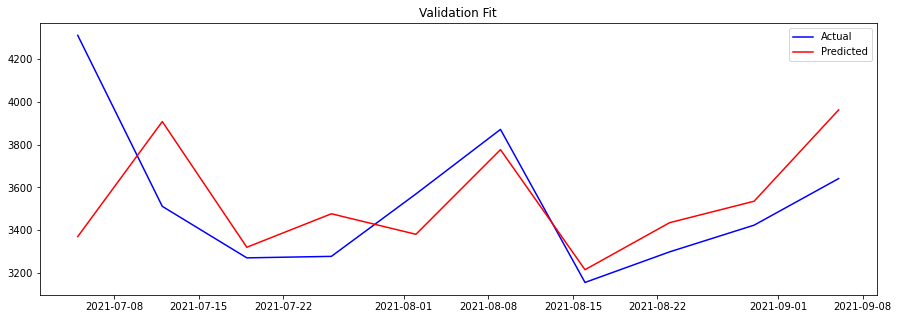

In [832]:
testp = RR.best_estimator_.predict(X_val)
testy = y_val
test_rmse = rmse(testy,testp)

print (test_rmse)
fig = plt.figure(figsize=(15,5))
plt.plot(X_val.index,testy,'b-',label='Actual')
plt.plot(X_val.index,testp,'r-',label='Predicted')
plt.legend()
plt.title('Validation Fit')
plt.show()

# Holdout Performance

In [849]:
y_holdout = data_holdout['FAA Lead Form Impressions']
X_holdout = data_holdout.drop('FAA Lead Form Impressions',axis=1).loc[:,best_dna.flatten()]
X_holdout.head()

,Search-National Brand,Search-Lumino Brand,Search-Lumino Generic,Social-Lumino,Display-Brand,Display-Lumino,Native-Brand,Native-Lumino,Native-GO,Video-Sponsorship,TV-Total-Brand-Imps,TV-Conv-Lumino-Imps,TV-Total-Spon-GRPs,TV-Spec-Brand-GRPs,TV-Spec-Spon-GRPs,LinkedIn EN-Brand,LinkedIn EN-Lumino,LinkedIn FR-Brand,LinkedIn FR-Lumino,Facebook-Other-DSP,LinkedIn EN-Lumino-DSP,LinkedIn EN-Other-DSP,Native-DV360-GO,Native-DV360-Lumino,Native-DCM-Brand,Native-DCM-GO,Native-DCM-Other,Display-DCM-Brand,Display-DCM-Lumino-B2B,Display-DCM-Other,Display-DCM-Sponsorship,Display-DV360-Lumino,Display-DV360-Other,Video-DV360-Other,Video-DV360-Sponsorships,CTV-DV360-Brand,Video-DCM-Sponsorship,PCOC-TV-Imps,TD-TV-Imps,Calls answered - GB,Emails answered - GRS,Manager,IND and GRP Client Count,IND and GRP Churn Rate,GB Churn Rate,GRS Client Count,GB and GRS Client Count,Bank rate,Chartered bank - consumer loan rate,Selected Government of Canada benchmark bond yields long term,Chartered bank - Guaranteed Investment Certificates 1 year,All other liabilities and capital,Treasury Bills,Weekly BCPI Excluding Energy - v52673504,Market Yield on U.S. Treasury Securities at 5-Year Constant Maturity,Christmas Day,New Year's Day,Thanksgiving
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-09-13,130683,2248,77702,836433.23,1819142,614342,814497,82252,0,0,752.490247,0.0,0.0,1.238342,0.0,22744,2920,15,0,0,2920,0,0,0,814497,0,0,0,0,83639,0,114283,0,0,0,0,0,15.616006,70381.265952,67816.0,622.0,166,191661.0,-0.0021,0.0109,913442.0,477774.0,0.5,7.7,1.77,0.25,1447,4722,446.24,0.810,0,0,0
2021-09-20,125152,2525,73944,940279.60,1975884,608022,593790,85048,0,0,199.181900,0.0,0.0,0.528428,0.0,19000,2890,17,0,53603,2890,0,0,0,593790,0,0,0,0,173925,0,108788,0,0,0,0,0,16473.269509,84319.999659,67288.0,586.0,166,191661.0,-0.0021,0.0109,913442.0,477774.0,0.5,7.7,1.75,0.25,1512,4062,444.55,0.830,0,0,0
2021-09-27,139471,2965,76924,911775.54,1540386,605110,267598,82857,0,0,1063.473310,0.0,0.0,1.743374,0.0,20360,2230,34,0,736382,2230,0,0,0,267598,0,0,0,0,334371,0,110438,0,0,0,0,0,16960.054916,74497.220677,68365.0,749.0,165,191661.0,-0.0021,0.0109,913442.0,477774.0,0.5,7.7,1.98,0.25,1557,4063,449.02,0.918,0,0,0
2021-10-04,142743,2765,73310,1851593.89,0,508161,661038,80503,0,0,0.000000,0.0,0.0,0.000000,0.0,61853,2951,108,0,951892,2951,0,0,0,661038,0,22503,0,0,245243,0,110850,593569,0,0,0,0,272.196127,65914.179783,71654.0,598.0,161,191902.0,0.0013,0.0094,916351.0,478325.0,0.5,7.7,1.99,0.25,1652,3713,452.80,0.978,0,0,0
2021-10-11,143109,2723,60068,2689247.98,0,479756,1022106,79385,0,0,34911.394990,0.0,0.0,52.984626,0.0,119636,2940,389,0,957650,2940,0,0,0,1022106,0,35430,0,0,259090,0,115420,2152059,0,0,0,0,14804.021100,82716.514931,58389.0,483.0,161,191902.0,0.0013,0.0094,916351.0,478325.0,0.5,7.7,2.02,0.25,1699,3273,461.78,1.010,0,0,1


In [852]:
'''
Fast saturation b = 0.2, Medium saturation b = 1, Slow saturation b = 2 
c = -1 for all as we want D-shaped curves, not S-shaped curves

Low carryover = 0.4, Medium carryover = 0.6, High carryover = 0.8
'''

holdout_media_transform = pd.DataFrame(columns = X_holdout.iloc[:,:X_holdout.columns.get_loc('TD-TV-Imps')+1].columns,index=X_holdout.index)

for col in X_holdout.iloc[:,:X_holdout.columns.get_loc('TD-TV-Imps')+1].columns:
    if any(x in col.lower() for x in ['video','ctv','youtube']):    
        carryover = np.convolve(X_holdout[col],carry(np.linspace(0,X_holdout.shape[0]),.6))[:len(X_holdout)]
        holdout_media_transform[col] = s_trans(carryover,b=1,c=-1)
    elif any(x in col.lower() for x in ['facebook','social','linkedin','twitter','search','display','native','audio','spotify']):
        carryover = np.convolve(X_holdout[col],carry(np.linspace(0,X_holdout.shape[0]),.4))[:len(X_holdout)]
        holdout_media_transform[col] = s_trans(carryover,b=0.2,c=-1)
    elif any(x in col.lower() for x in ['tv','ooh','radio']):
        carryover = np.convolve(X_holdout[col],carry(np.linspace(0,X_holdout.shape[0]),.8))[:len(X_holdout)]
        holdout_media_transform[col] = s_trans(carryover,b=2,c=-1)
    else:
        continue

C:\Users\NUPUR~1.GOK\AppData\Local\Temp/ipykernel_31716/3116124488.py:7: RuntimeWarning: divide by zero encountered in power
  s = 1/(1+b*(np.power(x/adstock,c)))


In [853]:
holdout_media_transform

,Search-National Brand,Search-Lumino Brand,Search-Lumino Generic,Social-Lumino,Display-Brand,Display-Lumino,Native-Brand,Native-Lumino,Native-GO,Video-Sponsorship,TV-Total-Brand-Imps,TV-Conv-Lumino-Imps,TV-Total-Spon-GRPs,TV-Spec-Brand-GRPs,TV-Spec-Spon-GRPs,LinkedIn EN-Brand,LinkedIn EN-Lumino,LinkedIn FR-Brand,LinkedIn FR-Lumino,Facebook-Other-DSP,LinkedIn EN-Lumino-DSP,LinkedIn EN-Other-DSP,Native-DV360-GO,Native-DV360-Lumino,Native-DCM-Brand,Native-DCM-GO,Native-DCM-Other,Display-DCM-Brand,Display-DCM-Lumino-B2B,Display-DCM-Other,Display-DCM-Sponsorship,Display-DV360-Lumino,Display-DV360-Other,Video-DV360-Other,Video-DV360-Sponsorships,CTV-DV360-Brand,Video-DCM-Sponsorship,PCOC-TV-Imps,TD-TV-Imps
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-09-13,0.643294,0.570749,0.528941,0.354458,0.583962,0.551826,0.525938,0.620261,0.000000,0.000000,0.005272,0.0,0.0,0.005132,0.0,0.299452,0.480171,0.028884,0.0,0.000000,0.088780,0.000000,0.0,0.0,0.525938,0.000000,0.000000,0.000000,0.0,0.093574,0.000000,0.562992,0.000000,0.0,0.0,0.000000,0.000000,0.000177,0.083358
2021-09-20,0.753948,0.712585,0.655301,0.506016,0.719514,0.680663,0.619966,0.743585,0.000000,0.000000,0.006290,0.0,0.0,0.006948,0.0,0.402632,0.615247,0.052815,0.0,0.162796,0.144322,0.000000,0.0,0.0,0.619966,0.000000,0.000000,0.000000,0.0,0.225534,0.000000,0.685683,0.000000,0.0,0.0,0.000000,0.000000,0.157557,0.162126
2021-09-27,0.807564,0.782226,0.716000,0.575915,0.755528,0.736363,0.611499,0.791469,0.000000,0.000000,0.013198,0.0,0.0,0.013580,0.0,0.468755,0.654099,0.098090,0.0,0.737911,0.166289,0.000000,0.0,0.0,0.611499,0.000000,0.000000,0.000000,0.0,0.385983,0.000000,0.741090,0.000000,0.0,0.0,0.000000,0.000000,0.268075,0.216396
2021-10-04,0.835559,0.811268,0.745457,0.689668,0.696168,0.755459,0.673989,0.815248,0.000000,0.000000,0.012282,0.0,0.0,0.012638,0.0,0.644972,0.700198,0.227669,0.0,0.847108,0.197653,0.000000,0.0,0.0,0.673989,0.000000,0.646160,0.000000,0.0,0.434634,0.000000,0.771260,0.389753,0.0,0.0,0.000000,0.000000,0.255737,0.254797
2021-10-11,0.851680,0.827514,0.752436,0.773400,0.629465,0.764816,0.745223,0.829003,0.000000,0.000000,0.204730,0.0,0.0,0.188713,0.0,0.782390,0.726897,0.497457,0.0,0.883475,0.219201,0.000000,0.0,0.0,0.745223,0.000000,0.808762,0.000000,0.0,0.470834,0.000000,0.791709,0.736088,0.0,0.0,0.000000,0.000000,0.327681,0.298130
2021-10-18,0.860063,0.842249,0.747028,0.813774,0.680045,0.770046,0.771125,0.837201,0.000000,0.000000,0.355647,0.0,0.0,0.343585,0.0,0.822687,0.743772,0.567642,0.0,0.898285,0.234405,0.000000,0.0,0.0,0.771125,0.000000,0.852701,0.000148,0.0,0.517042,0.000000,0.801038,0.841254,0.0,0.0,0.259719,0.000000,0.312810,0.317300
2021-10-25,0.866979,0.852281,0.739654,0.843350,0.782476,0.777438,0.808023,0.842311,0.000000,0.000000,0.478641,0.0,0.0,0.472081,0.0,0.841703,0.755752,0.594671,0.0,0.871790,0.246061,0.488113,0.0,0.0,0.808023,0.000000,0.874095,0.601882,0.0,0.743934,0.000000,0.807707,0.876687,0.0,0.0,0.466329,0.000000,0.368932,0.350163
2021-11-01,0.856832,0.855173,0.815319,0.893960,0.833061,0.794323,0.846853,0.845150,0.000000,0.000000,0.466349,0.0,0.0,0.463371,0.0,0.859469,0.765303,0.617328,0.0,0.910303,0.718629,0.727542,0.0,0.0,0.846853,0.000000,0.885546,0.734094,0.0,0.813402,0.000000,0.863243,0.853061,0.0,0.0,0.606624,0.000000,0.352721,0.360964
2021-11-08,0.857258,0.860162,0.850805,0.892767,0.854975,0.793253,0.864984,0.846074,0.000000,0.000000,0.449536,0.0,0.0,0.447332,0.0,0.867487,0.772375,0.595090,0.0,0.908501,0.781759,0.812990,0.0,0.0,0.864984,0.000000,0.892776,0.786138,0.0,0.881924,0.957322,0.879474,0.832173,0.0,0.0,0.714393,0.000000,0.399932,0.380064


In [835]:
'''
Fast saturation b = 0.2, Medium saturation b = 1, Slow saturation b = 2 
c = -1 for all as we want D-shaped curves, not S-shaped curves
'''

holdout_media_transform = pd.DataFrame(columns = X_holdout.iloc[:,:X_holdout.columns.get_loc('Video-DCM-Other')+1].columns)

for col in X_holdout.iloc[:,1:X_holdout.columns.get_loc('Video-DCM-Other')+1].columns:
    if any(x in col.lower() for x in ['video','ctv','youtube']):
        holdout_media_transform[col] = s_trans(X_holdout[col],b=1,c=-1)
    elif any(x in col.lower() for x in ['facebook','social','linkedin','twitter','search','display','native','audio','spotify']):
        holdout_media_transform[col] = s_trans(X_holdout[col],b=0.2,c=-1)
    elif any(x in col.lower() for x in ['tv','ooh','radio']):
        holdout_media_transform[col] = s_trans(X_holdout[col],b=2,c=-1)
    else:
        continue

C:\Users\NUPUR~1.GOK\AppData\Local\Temp/ipykernel_31716/3116124488.py:7: RuntimeWarning: divide by zero encountered in power
  s = 1/(1+b*(np.power(x/adstock,c)))


In [854]:
holdout_media_transform.fillna(0,inplace=True)
X_holdout.iloc[:,:X_holdout.columns.get_loc('TD-TV-Imps')+1] = holdout_media_transform
X_holdout.head()

,Search-National Brand,Search-Lumino Brand,Search-Lumino Generic,Social-Lumino,Display-Brand,Display-Lumino,Native-Brand,Native-Lumino,Native-GO,Video-Sponsorship,TV-Total-Brand-Imps,TV-Conv-Lumino-Imps,TV-Total-Spon-GRPs,TV-Spec-Brand-GRPs,TV-Spec-Spon-GRPs,LinkedIn EN-Brand,LinkedIn EN-Lumino,LinkedIn FR-Brand,LinkedIn FR-Lumino,Facebook-Other-DSP,LinkedIn EN-Lumino-DSP,LinkedIn EN-Other-DSP,Native-DV360-GO,Native-DV360-Lumino,Native-DCM-Brand,Native-DCM-GO,Native-DCM-Other,Display-DCM-Brand,Display-DCM-Lumino-B2B,Display-DCM-Other,Display-DCM-Sponsorship,Display-DV360-Lumino,Display-DV360-Other,Video-DV360-Other,Video-DV360-Sponsorships,CTV-DV360-Brand,Video-DCM-Sponsorship,PCOC-TV-Imps,TD-TV-Imps,Calls answered - GB,Emails answered - GRS,Manager,IND and GRP Client Count,IND and GRP Churn Rate,GB Churn Rate,GRS Client Count,GB and GRS Client Count,Bank rate,Chartered bank - consumer loan rate,Selected Government of Canada benchmark bond yields long term,Chartered bank - Guaranteed Investment Certificates 1 year,All other liabilities and capital,Treasury Bills,Weekly BCPI Excluding Energy - v52673504,Market Yield on U.S. Treasury Securities at 5-Year Constant Maturity,Christmas Day,New Year's Day,Thanksgiving
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-09-13,0.643294,0.570749,0.528941,0.354458,0.583962,0.551826,0.525938,0.620261,0.0,0.0,0.005272,0.0,0.0,0.005132,0.0,0.299452,0.480171,0.028884,0.0,0.000000,0.088780,0.0,0.0,0.0,0.525938,0.0,0.000000,0.0,0.0,0.093574,0.0,0.562992,0.000000,0.0,0.0,0.0,0.0,0.000177,0.083358,67816.0,622.0,166,191661.0,-0.0021,0.0109,913442.0,477774.0,0.5,7.7,1.77,0.25,1447,4722,446.24,0.810,0,0,0
2021-09-20,0.753948,0.712585,0.655301,0.506016,0.719514,0.680663,0.619966,0.743585,0.0,0.0,0.006290,0.0,0.0,0.006948,0.0,0.402632,0.615247,0.052815,0.0,0.162796,0.144322,0.0,0.0,0.0,0.619966,0.0,0.000000,0.0,0.0,0.225534,0.0,0.685683,0.000000,0.0,0.0,0.0,0.0,0.157557,0.162126,67288.0,586.0,166,191661.0,-0.0021,0.0109,913442.0,477774.0,0.5,7.7,1.75,0.25,1512,4062,444.55,0.830,0,0,0
2021-09-27,0.807564,0.782226,0.716000,0.575915,0.755528,0.736363,0.611499,0.791469,0.0,0.0,0.013198,0.0,0.0,0.013580,0.0,0.468755,0.654099,0.098090,0.0,0.737911,0.166289,0.0,0.0,0.0,0.611499,0.0,0.000000,0.0,0.0,0.385983,0.0,0.741090,0.000000,0.0,0.0,0.0,0.0,0.268075,0.216396,68365.0,749.0,165,191661.0,-0.0021,0.0109,913442.0,477774.0,0.5,7.7,1.98,0.25,1557,4063,449.02,0.918,0,0,0
2021-10-04,0.835559,0.811268,0.745457,0.689668,0.696168,0.755459,0.673989,0.815248,0.0,0.0,0.012282,0.0,0.0,0.012638,0.0,0.644972,0.700198,0.227669,0.0,0.847108,0.197653,0.0,0.0,0.0,0.673989,0.0,0.646160,0.0,0.0,0.434634,0.0,0.771260,0.389753,0.0,0.0,0.0,0.0,0.255737,0.254797,71654.0,598.0,161,191902.0,0.0013,0.0094,916351.0,478325.0,0.5,7.7,1.99,0.25,1652,3713,452.80,0.978,0,0,0
2021-10-11,0.851680,0.827514,0.752436,0.773400,0.629465,0.764816,0.745223,0.829003,0.0,0.0,0.204730,0.0,0.0,0.188713,0.0,0.782390,0.726897,0.497457,0.0,0.883475,0.219201,0.0,0.0,0.0,0.745223,0.0,0.808762,0.0,0.0,0.470834,0.0,0.791709,0.736088,0.0,0.0,0.0,0.0,0.327681,0.298130,58389.0,483.0,161,191902.0,0.0013,0.0094,916351.0,478325.0,0.5,7.7,2.02,0.25,1699,3273,461.78,1.010,0,0,1


4530.019337522919


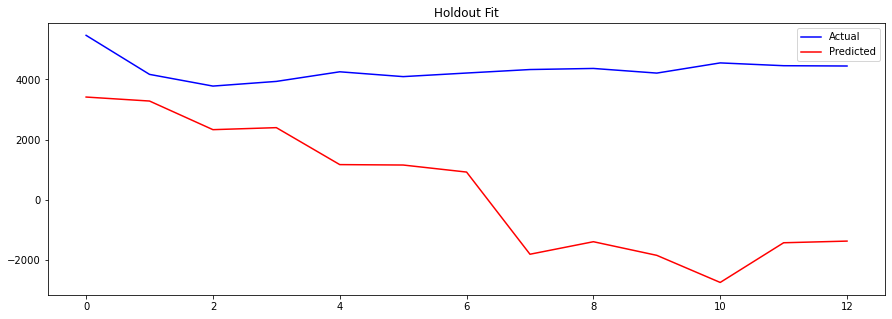

In [855]:
testp = RR.best_estimator_.predict(X_holdout)[:-3]
testy = y_holdout[:-3]
test_rmse = rmse(testy,testp)

print (test_rmse)
fig = plt.figure(figsize=(15,5))
plt.plot(np.arange(testy.shape[0]),testy,'b-',label='Actual')
plt.plot(np.arange(testp.shape[0]),testp,'r-',label='Predicted')
plt.legend()
plt.title('Holdout Fit')
plt.show()